In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install rdkit networkx matplotlib

# Topological graph

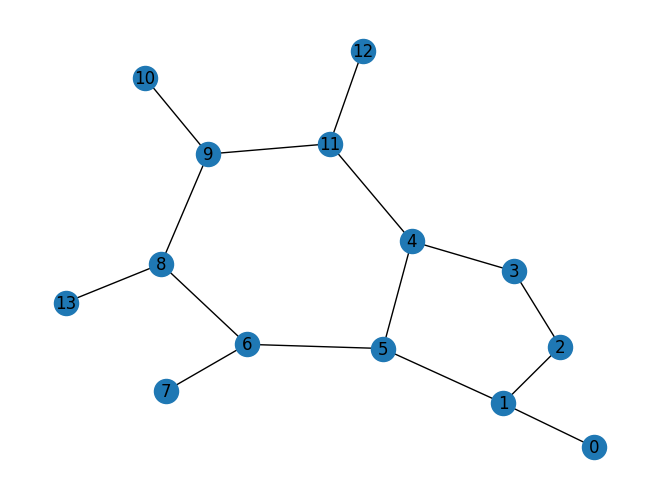

In [78]:
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt

mol_smile = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

mol = Chem.MolFromSmiles(mol_smile)
import networkx as nx
G = nx.Graph()
for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), atomic_num=atom.GetAtomicNum())
for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondTypeAsDouble())

mol_graph = G

import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)
plt.show()



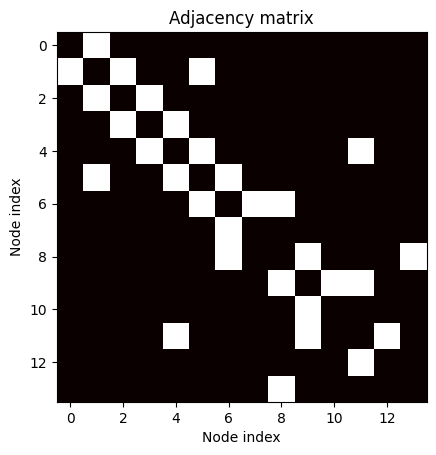

In [79]:
import numpy as np
A = nx.adjacency_matrix(G).todense()
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.xlabel('Node index')
plt.ylabel('Node index')
plt.title('Adjacency matrix')
plt.show()

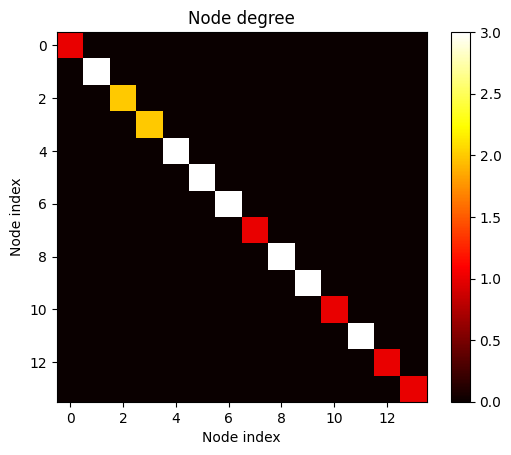

In [80]:
node_degree = np.diag(list(dict(G.degree()).values()))

plt.imshow(node_degree, cmap='hot', interpolation='nearest')
plt.xlabel('Node index')
plt.ylabel('Node index')
plt.title('Node degree')
plt.colorbar()
plt.show()


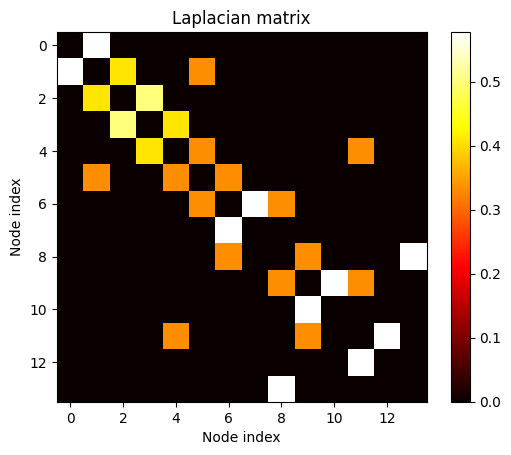

In [81]:
# L = D^(-1/2)AD^(-1/2)
L = np.dot(np.dot(np.diag(1/np.sqrt(np.diag(node_degree))), A), np.diag(1/np.sqrt(np.diag(node_degree))))
plt.imshow(L, cmap='hot', interpolation='nearest')
plt.xlabel('Node index')
plt.ylabel('Node index')
plt.title('Laplacian matrix')
plt.colorbar()
plt.show()

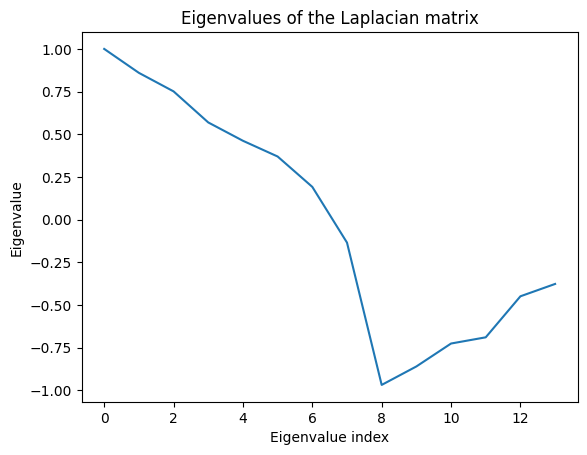

In [83]:
# eigendecomposition

eigenvalues, eigenvectors = np.linalg.eig(L)
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Laplacian matrix')
plt.show()


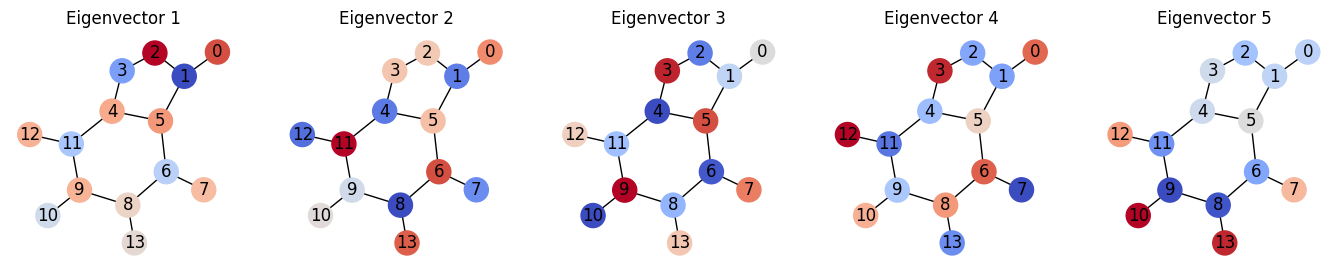

In [90]:
# sort the eigenvectors by eigenvalues
sorted_eigenvectors = eigenvectors[:,np.argsort(eigenvalues)]

pos = nx.spring_layout(G)
fig = plt.figure(figsize=(17, 3))
for i in range(1, 6):
    plt.subplot(1, 5, i)
    nx.draw(G, pos, node_color=sorted_eigenvectors[:,i], cmap=plt.cm.coolwarm, with_labels=True)
    plt.title('Eigenvector {}'.format(i))
plt.show()


# Geometrical graph

In [59]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

mol_smile = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

mol = Chem.MolFromSmiles(mol_smile)
# relax the molecule
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
coords = mol.GetConformer().GetPositions()
atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
atomic_nums = np.array(atomic_nums)



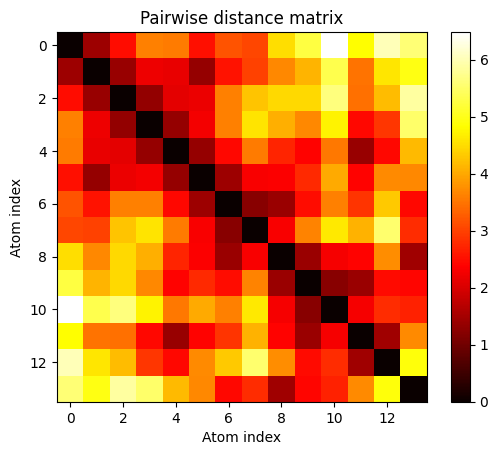

In [60]:
# show the pairwise distance matrix excluding the H atoms
import numpy as np
from scipy.spatial.distance import pdist, squareform
coords = np.array([coord for i, coord in enumerate(coords) if atomic_nums[i] != 1])
dist_mat = squareform(pdist(coords))
plt.imshow(dist_mat, cmap='hot', interpolation='nearest')
plt.xlabel('Atom index')
plt.ylabel('Atom index')
plt.title('Pairwise distance matrix')
plt.colorbar()
plt.show()

In [62]:
from ase import Atoms
from ase.visualize import view

# exclude the H atoms
atomic_nums = np.array([num for num in atomic_nums if num != 1])
ase_atoms = Atoms(positions=coords, numbers=atomic_nums)
view(ase_atoms)


<Popen: returncode: None args: ['/Users/zpengmei/anaconda3/envs/graph/bin/py...>

In [72]:
from torch_geometric.data import Data
import torch

data = Data(x=torch.tensor(atomic_nums).view(-1, 1).float(),pos=torch.tensor(coords).float(),edge_index=torch.tensor(list(G.edges)).t().contiguous())
data

Data(x=[14, 1], edge_index=[2, 50], pos=[14, 3])

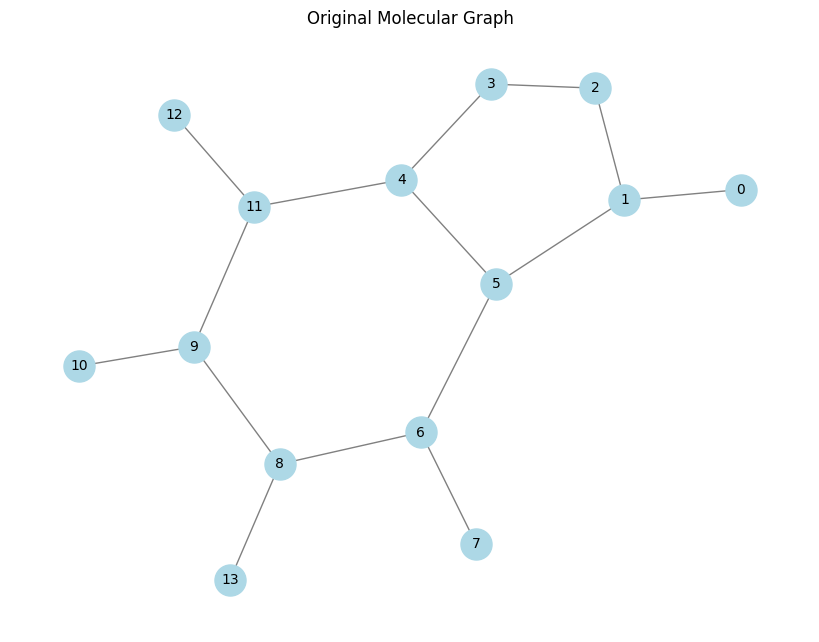

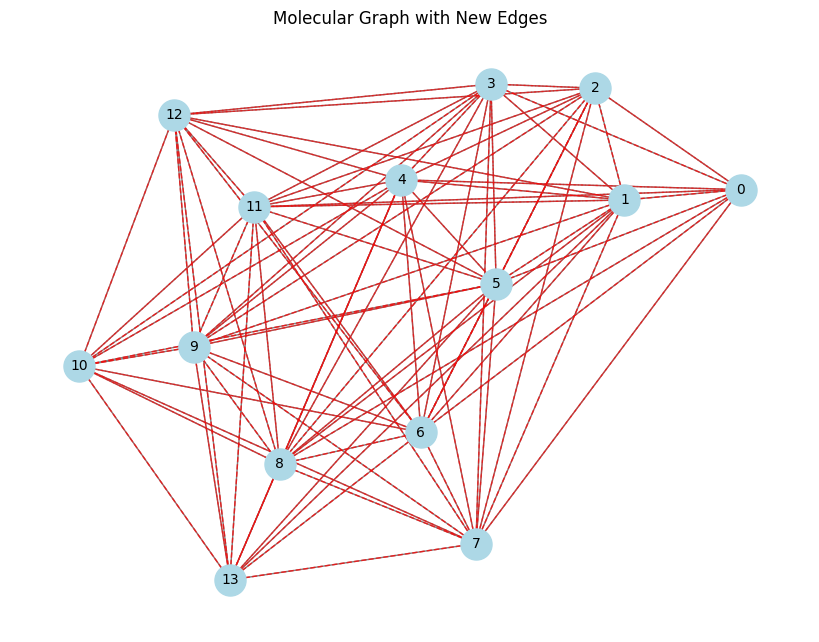

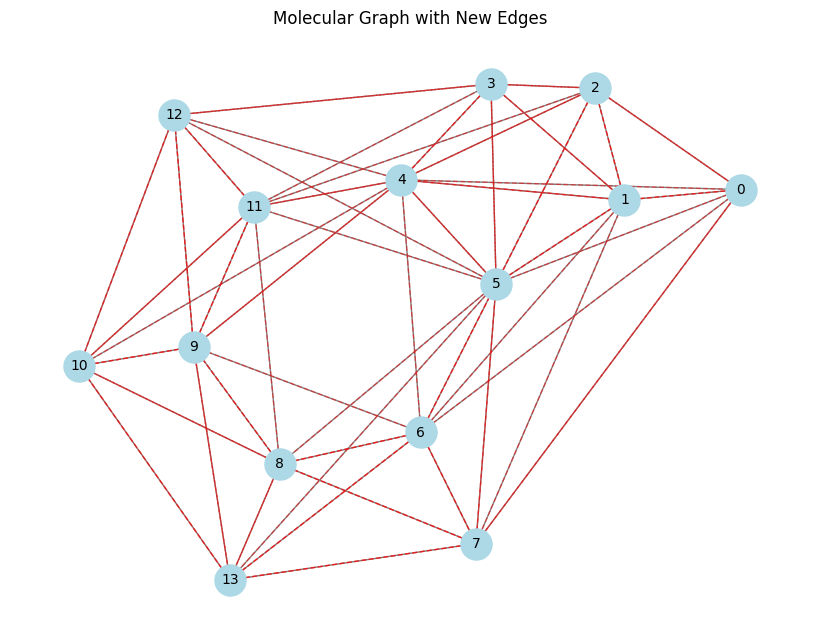

In [69]:
import torch
from torch_geometric.transforms import RadiusGraph, KNNGraph
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

radius_transform = RadiusGraph(r=5.0)
radius_data = radius_transform(data)
radius_edge = radius_data.edge_index

knn_transform = KNNGraph(k=6)
knn_data = knn_transform(data)
knn_edge = knn_data.edge_index

mol_graph = mol_graph  
G = deepcopy(mol_graph)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', edge_color='gray')
plt.title('Original Molecular Graph')
plt.show()

# Add new edges to the graph
for i in range(radius_edge.size(1)):
    G.add_edge(radius_edge[0, i].item(), radius_edge[1, i].item())

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=[(radius_edge[0, i].item(), radius_edge[1, i].item()) for i in range(radius_edge.size(1))],
                       edge_color='r', style='dashed', alpha=0.5)
plt.title('Molecular Graph with New Edges')
plt.show()

# Add new edges to the graph
G = deepcopy(mol_graph)
for i in range(knn_edge.size(1)):
    G.add_edge(knn_edge[0, i].item(), knn_edge[1, i].item())

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=[(knn_edge[0, i].item(), knn_edge[1, i].item()) for i in range(knn_edge.size(1))],
                       edge_color='r', style='dashed', alpha=0.5)
plt.title('Molecular Graph with New Edges')
plt.show()





In [71]:
data

Data(x=[14, 1], pos=[14, 3])

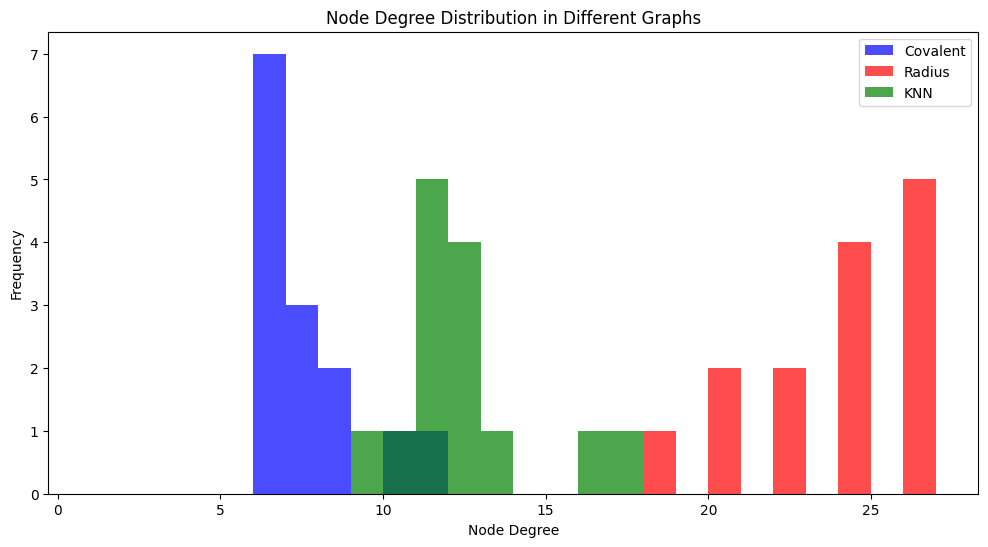

In [75]:
# count the node degree in three different graphs

covalent_graph = data
radius_graph = radius_data
knn_graph = knn_data

def calculate_node_degrees(edge_index, num_nodes):
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    for i in range(edge_index.size(1)):
        degrees[edge_index[0, i]] += 1
        degrees[edge_index[1, i]] += 1
    return degrees

num_nodes = data.num_nodes

covalent_degrees = calculate_node_degrees(covalent_graph.edge_index, num_nodes)
radius_degrees = calculate_node_degrees(radius_graph.edge_index, num_nodes)
knn_degrees = calculate_node_degrees(knn_graph.edge_index, num_nodes)

plt.figure(figsize=(12, 6))

plt.hist(covalent_degrees.numpy(), bins=range(1, max(covalent_degrees)+2), alpha=0.7, color='blue', label='Covalent')
plt.hist(radius_degrees.numpy(), bins=range(1, max(radius_degrees)+2), alpha=0.7, color='red', label='Radius')
plt.hist(knn_degrees.numpy(), bins=range(1, max(knn_degrees)+2), alpha=0.7, color='green', label='KNN')

plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Distribution in Different Graphs')
plt.legend(loc='upper right')
plt.show()


